In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import seaborn as sns
import pickle
sns.set_context('poster')
import glob
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, plot_roc_curve
from scipy.stats import pearsonr, spearmanr
from scipy.stats import wasserstein_distance
import os
import gn4pions.modules.resolution_util as ru
import gn4pions.modules.plot_util as pu
import atlas_mpl_style as ampl
import matplotlib as mpl
import scipy.stats as stats
ampl.use_atlas_style()
plt.style.use('print')
ampl.set_color_cycle('Oceanic',10)

In [2]:
pion_dir = '/usr/workspace/hip/ML4Jets/regression_images/graphs.v01-45-gaa27bcb/onetrack_multicluster/pion_files/'
pion_files = np.sort(glob.glob(pion_dir+"*.npy"))
n_files = 50

In [3]:
def create_expanded_df(pion_dir, n_files):
    
    pion_files = np.sort(glob.glob(pion_dir+"*.npy"))
    file_name = pion_dir+'/expanded_df_dropped_first_'+str(n_files)+'.pkl'
    if os.path.exists(file_name):
        print('Pickle file already present, loading...', end='')
        df_expanded = pd.read_pickle(file_name)
        print('done!')
        return df_expanded
    
    df = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(pion_files[:n_files], desc='Loading files to one df')])
    
    track_variables = ['trackPt', 'trackD0', 'trackZ0',
                   'trackEta_EMB2', 'trackPhi_EMB2', 
                   'trackEta', 'trackPhi',
                   'truthPartE', 'truthPartPt']
    for v in tqdm(track_variables, desc='Converting track variables array to scalar'):
        df[v] = df[v].explode()
        
    df.reset_index(inplace=True, drop=True)
    df_expanded = df.loc[df.index.repeat(df.nCluster)]
    
    cluster_variables = ['cluster_cell_E', 'cluster_cell_ID',
                     'cluster_ENG_CALIB_TOT', 'cluster_E', 
                     'cluster_Eta', 'cluster_Phi',
                     'cluster_EM_PROBABILITY', 'cluster_E_LCCalib', 
                     'cluster_HAD_WEIGHT', 'dR']

    for v in tqdm(cluster_variables, desc='Exploding cluster variables'):
        df_expanded[v] = df[v].explode()
        
    df_expanded.reset_index(inplace=True)
    df_expanded.rename(columns={'index': 'event_index'}, inplace=True)
    
    print('Saving df to pickle file...', end='')
    df_expanded.to_pickle(pion_dir+'/expanded_df_dropped_first_'+str(n_files)+'.pkl')
    print('done!')
    return df_expanded

In [4]:
df_expanded = create_expanded_df(pion_dir, n_files)

Pickle file already present, loading...done!


In [5]:
df_expanded['cluster_Et'] = df_expanded['cluster_E']/np.cosh(df_expanded['cluster_Eta'].astype(np.float32).values)
df_expanded['track_P'] = df_expanded['trackPt']*np.cosh(df_expanded['trackEta'].astype(np.float32).values)
df_expanded.head(10)

,event_index,cluster_cell_E,cluster_cell_ID,trackPt,trackD0,trackZ0,trackEta_EMB2,trackPhi_EMB2,trackEta_EME2,trackPhi_EME2,...,cluster_Phi,cluster_EM_PROBABILITY,cluster_E_LCCalib,cluster_HAD_WEIGHT,num_tracks,dR,dR_pass,event_number,cluster_Et,track_P
0,0,"(421.69482, 7.1292477, 6.2763577, 13.232551, 3...","(1140850704, 1141882896, 1140867088, 114085096...",569.970337,0.000113,-51.260349,-0.046391,0.053458,[-1000000000.0],[-1000000000.0],...,0.04962,0.001,655.797668,1.125807,1,0.002569,1,0,540.329025,570.583751
1,1,"(0.6589358, 0.46683934, 0.08905287, 0.04709196...","(767562746, 767562744, 767562748, 767562234, 7...",6.749092,0.032816,-23.837978,0.250689,-0.115179,[-1000000000.0],[-1000000000.0],...,-0.068763,0.208537,5.422934,1.097062,1,0.064276,2,1,3.31082,6.962278
2,1,"(1.0459431, 0.031357095, 0.07751729, 0.0222386...","(1149239568, 1149239312, 1149239824, 115027150...",6.749092,0.032816,-23.837978,0.250689,-0.115179,[-1000000000.0],[-1000000000.0],...,0.047927,0.000131,2.406084,1.397523,1,0.111287,2,1,1.109161,6.962278
3,2,"(51.25548, 14.139051, 3.7185004, 3.4223423, 11...","(751052484, 751052482, 751052486, 751051972, 7...",170.099106,0.006046,-59.106083,-1000000000.0,-1000000000.0,[-1.9193797],[2.4169002],...,2.413878,0.002079,354.839386,1.093978,1,0.015788,2,2,79.658727,592.236115
4,2,"(0.86780506, 0.28949308, 0.08377968, 29.631582...","(823750656, 823492608, 823496704, 823230464, 8...",170.099106,0.006046,-59.106083,-1000000000.0,-1000000000.0,[-1.9193797],[2.4169002],...,2.417361,0.000447,254.887375,1.145813,1,0.015775,2,2,57.213934,592.236115
5,2,"(0.3760324, 0.009026994, 0.071052454, 0.046044...","(778047546, 778047544, 778047548, 778047034, 7...",170.099106,0.006046,-59.106083,-1000000000.0,-1000000000.0,[-1.9193797],[2.4169002],...,0.724966,0.006793,2.400411,1.199628,1,4.214539,2,2,0.211452,592.236115
6,3,"(4.963051, 0.48994341, 1.8525301, 0.11810666, ...","(759186902, 759186900, 759186904, 759186390, 7...",37.497395,0.008977,-41.75296,-0.850701,-0.49864,[-1000000000.0],[-1000000000.0],...,-0.522446,0.000479,38.971966,1.131061,1,0.042908,2,3,19.677339,51.902668
7,3,"(0.5600088, 0.18596545, 0.39653927, 0.26549253...","(1141851904, 1141851648, 1141835264, 114185166...",37.497395,0.008977,-41.75296,-0.850701,-0.49864,[-1000000000.0],[-1000000000.0],...,-0.405816,0.000402,10.388762,1.234548,1,0.098411,2,3,5.646238,51.902668
8,4,"(38.615395, 9.545481, 1.824186, 1.844402, 0.06...","(778045022, 778045020, 778045024, 778044510, 7...",87.00473,-0.002006,69.096138,-1000000000.0,-1000000000.0,[1.6544152],[1.1558621],...,1.147337,0.002325,231.486298,1.105973,1,0.016476,2,4,64.108275,235.837233
9,4,"(2.3611054, 1.7487121, 0.27327454, 1.4193809, ...","(847822848, 847818752, 847560704, 847556608, 8...",87.00473,-0.002006,69.096138,-1000000000.0,-1000000000.0,[1.6544152],[1.1558621],...,1.164553,0.000953,20.590845,1.180685,1,0.074552,2,4,4.165916,235.837233


In [6]:
df_expanded['cluster_E'].astype(np.float32).apply(np.log10).describe()

count    1.436000e+06
mean     8.975424e-01
std      1.058209e+00
min     -4.743679e+00
25%      3.013510e-02
50%      7.786727e-01
75%      1.711300e+00
max      3.299862e+00
Name: cluster_E, dtype: float64

In [7]:
def histPlot(x, y, xbin, ybin, statistic='median',
             xscale='log', yscale='linear',
             xlabel=None, ylabel=None,
             draw_stat=True, figsize=(10,4)):

    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
    profileXMed = stats.binned_statistic(
        x, y, bins=xbin, statistic=statistic).statistic

    c_map = mpl.colors.ListedColormap(sns.color_palette("Blues", n_colors=100).as_hex())

    fig = plt.figure(figsize=figsize)
    fig.patch.set_facecolor('white')
    plt.hist2d(x, y, bins=[xbin, ybin], norm=mpl.colors.LogNorm(),zorder = -1, cmap=c_map)
    if draw_stat:
        plt.plot(xcenter, profileXMed, color='indianred')
    plt.xscale(xscale)
    plt.yscale(yscale)

    pu.ampl.set_xlabel(xlabel, fontsize=20)
    pu.ampl.set_ylabel(ylabel, fontsize=20)

    cb = plt.colorbar()

    plt.show()

    return


def iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q84, q16 = np.percentile(x, [84, 16])
    iqr = q84 - q16
    med = np.median(x)
    return iqr / (2*med)


def resolutionPlot(x, y, xbin, statistic='std',
                   xlabel=None, ylabel=None):
    
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
    if statistic == 'std': # or any other baseline one?
        resolution = stats.binned_statistic(x, y, bins=xbin,statistic=statistic).statistic
    elif statistic == 'stdOverMean':
        resolution = stats.binned_statistic(x, y, bins=xbin,statistic=stdOverMean).statistic
    elif statistic == 'iqrOverMed':
        resolution = stats.binned_statistic(x, y, bins=xbin,statistic=iqrOverMed).statistic

    plt.cla(); plt.clf()
    fig = plt.figure(figsize=(10,4))
    fig.patch.set_facecolor('white')
    plt.plot(xcenter, resolution)
    plt.xscale('log')
#     plt.xlim(0.1, 1000)
#     plt.ylim(0,0.1)
    pu.ampl.set_xlabel(xlabel, fontsize=20)
    pu.ampl.set_ylabel(ylabel, fontsize=20)

#     pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

#     if figfile != '':
#         plt.savefig(figfile)
    plt.show()

    return # xcenter, resolution

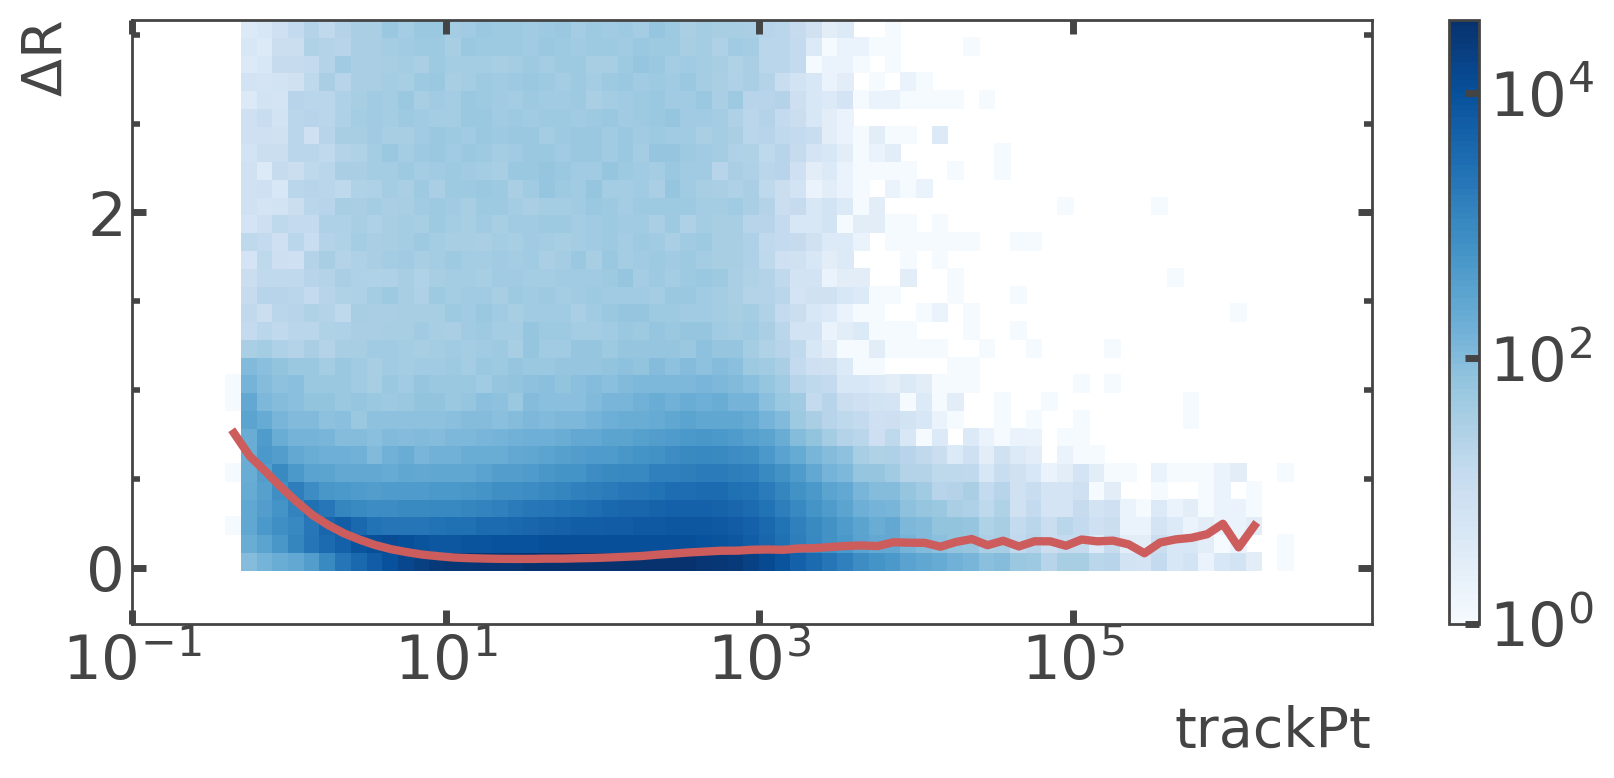

<Figure size 1600x1200 with 0 Axes>

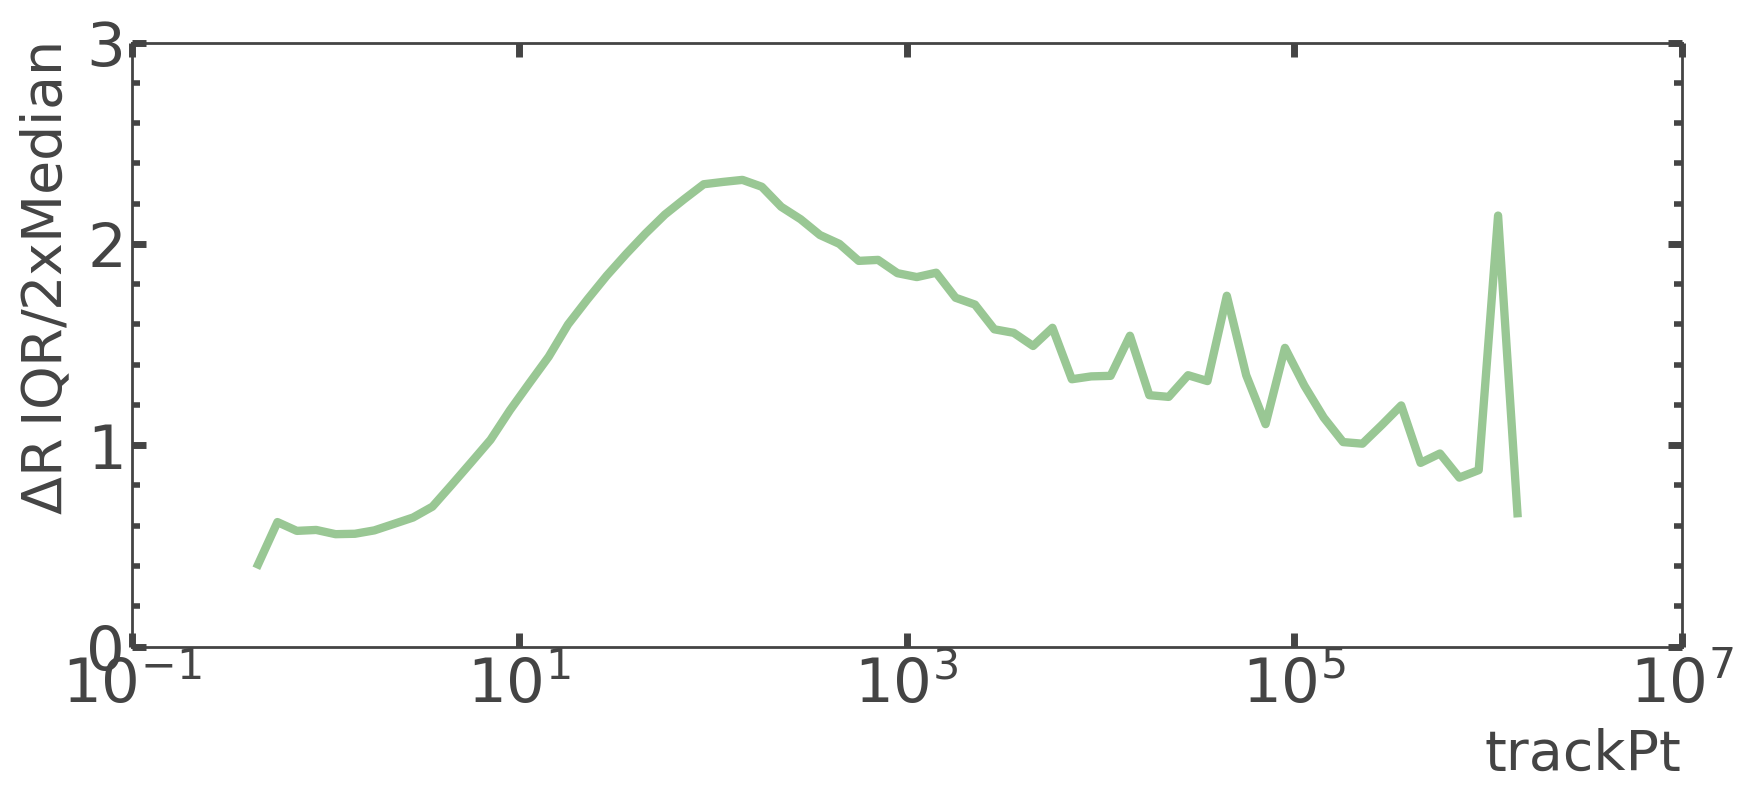

In [8]:
x_bins = [10**exp for exp in np.arange(-1, 7, .1)] 
y_bins = np.arange(-.1*np.pi, 1*np.pi, .1)
trackPt = df_expanded.trackPt.astype(np.float32).values
deltaR = df_expanded.dR.astype(np.float32).values
histPlot(trackPt, deltaR, xbin=x_bins, ybin=y_bins,
         xlabel='trackPt', ylabel='$\Delta R$')

resolutionPlot(trackPt, deltaR, xbin=x_bins,
               statistic='iqrOverMed',
               xlabel='trackPt', ylabel='$\Delta R\: IQR/2xMedian$')

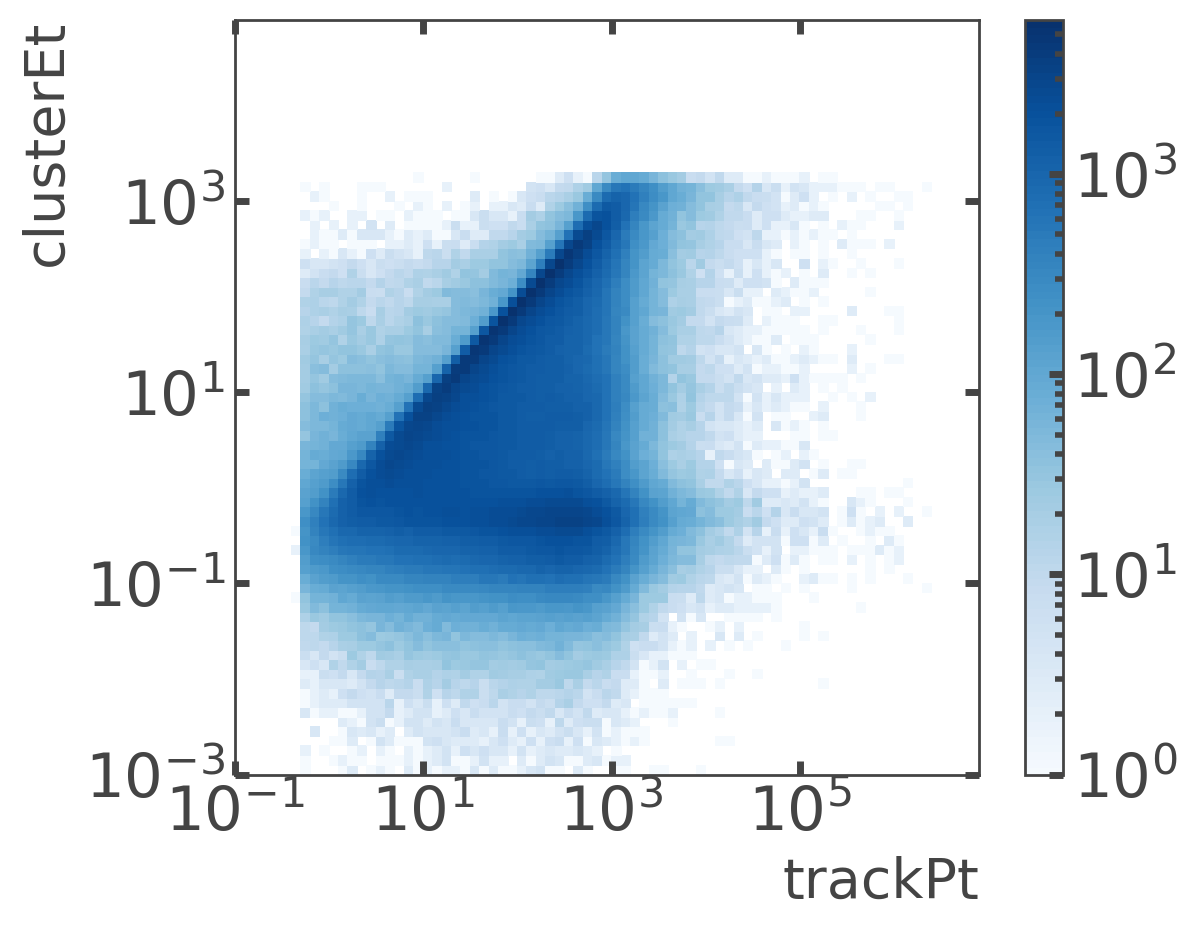

In [9]:
x_bins = [10**exp for exp in np.arange(-1, 7, .1)] 
y_bins = [10**exp for exp in np.arange(-3, 5, .1)] 
trackPt = df_expanded.trackPt.astype(np.float32).values
cluster_Et = df_expanded.cluster_Et.astype(np.float32).values
histPlot(trackPt, cluster_Et, xbin=x_bins, ybin=y_bins,
         xscale='log', yscale='log', draw_stat=False,
         xlabel='trackPt', ylabel='clusterEt', figsize=(6,5))


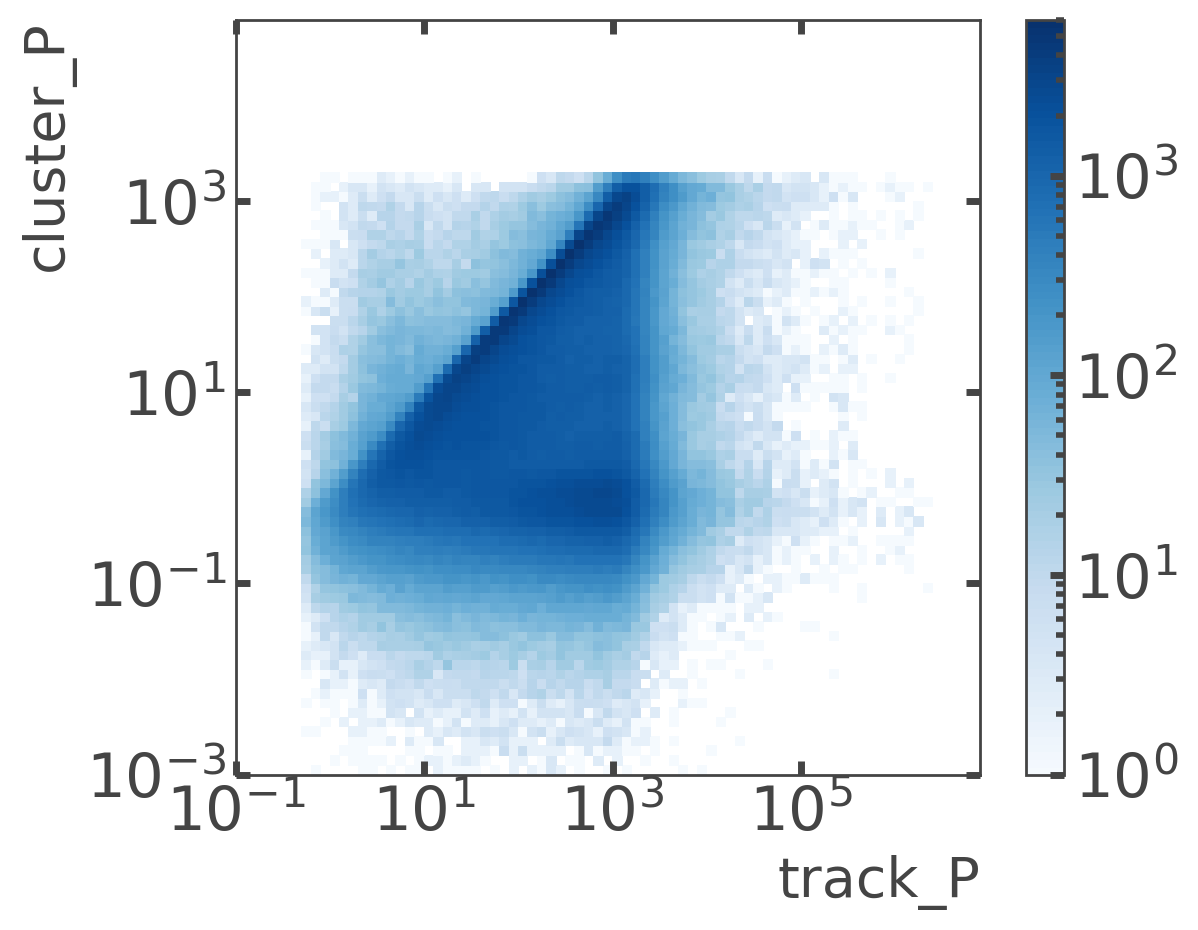

In [10]:
x_bins = [10**exp for exp in np.arange(-1, 7, .1)] 
y_bins = [10**exp for exp in np.arange(-3, 5, .1)] 
trackP = df_expanded.track_P.astype(np.float32).values
cluster_E = df_expanded.cluster_E.astype(np.float32).values
histPlot(trackP, cluster_E, xbin=x_bins, ybin=y_bins,
         xscale='log', yscale='log', draw_stat=False,
         xlabel='track_P', ylabel='cluster_P', figsize=(6,5))

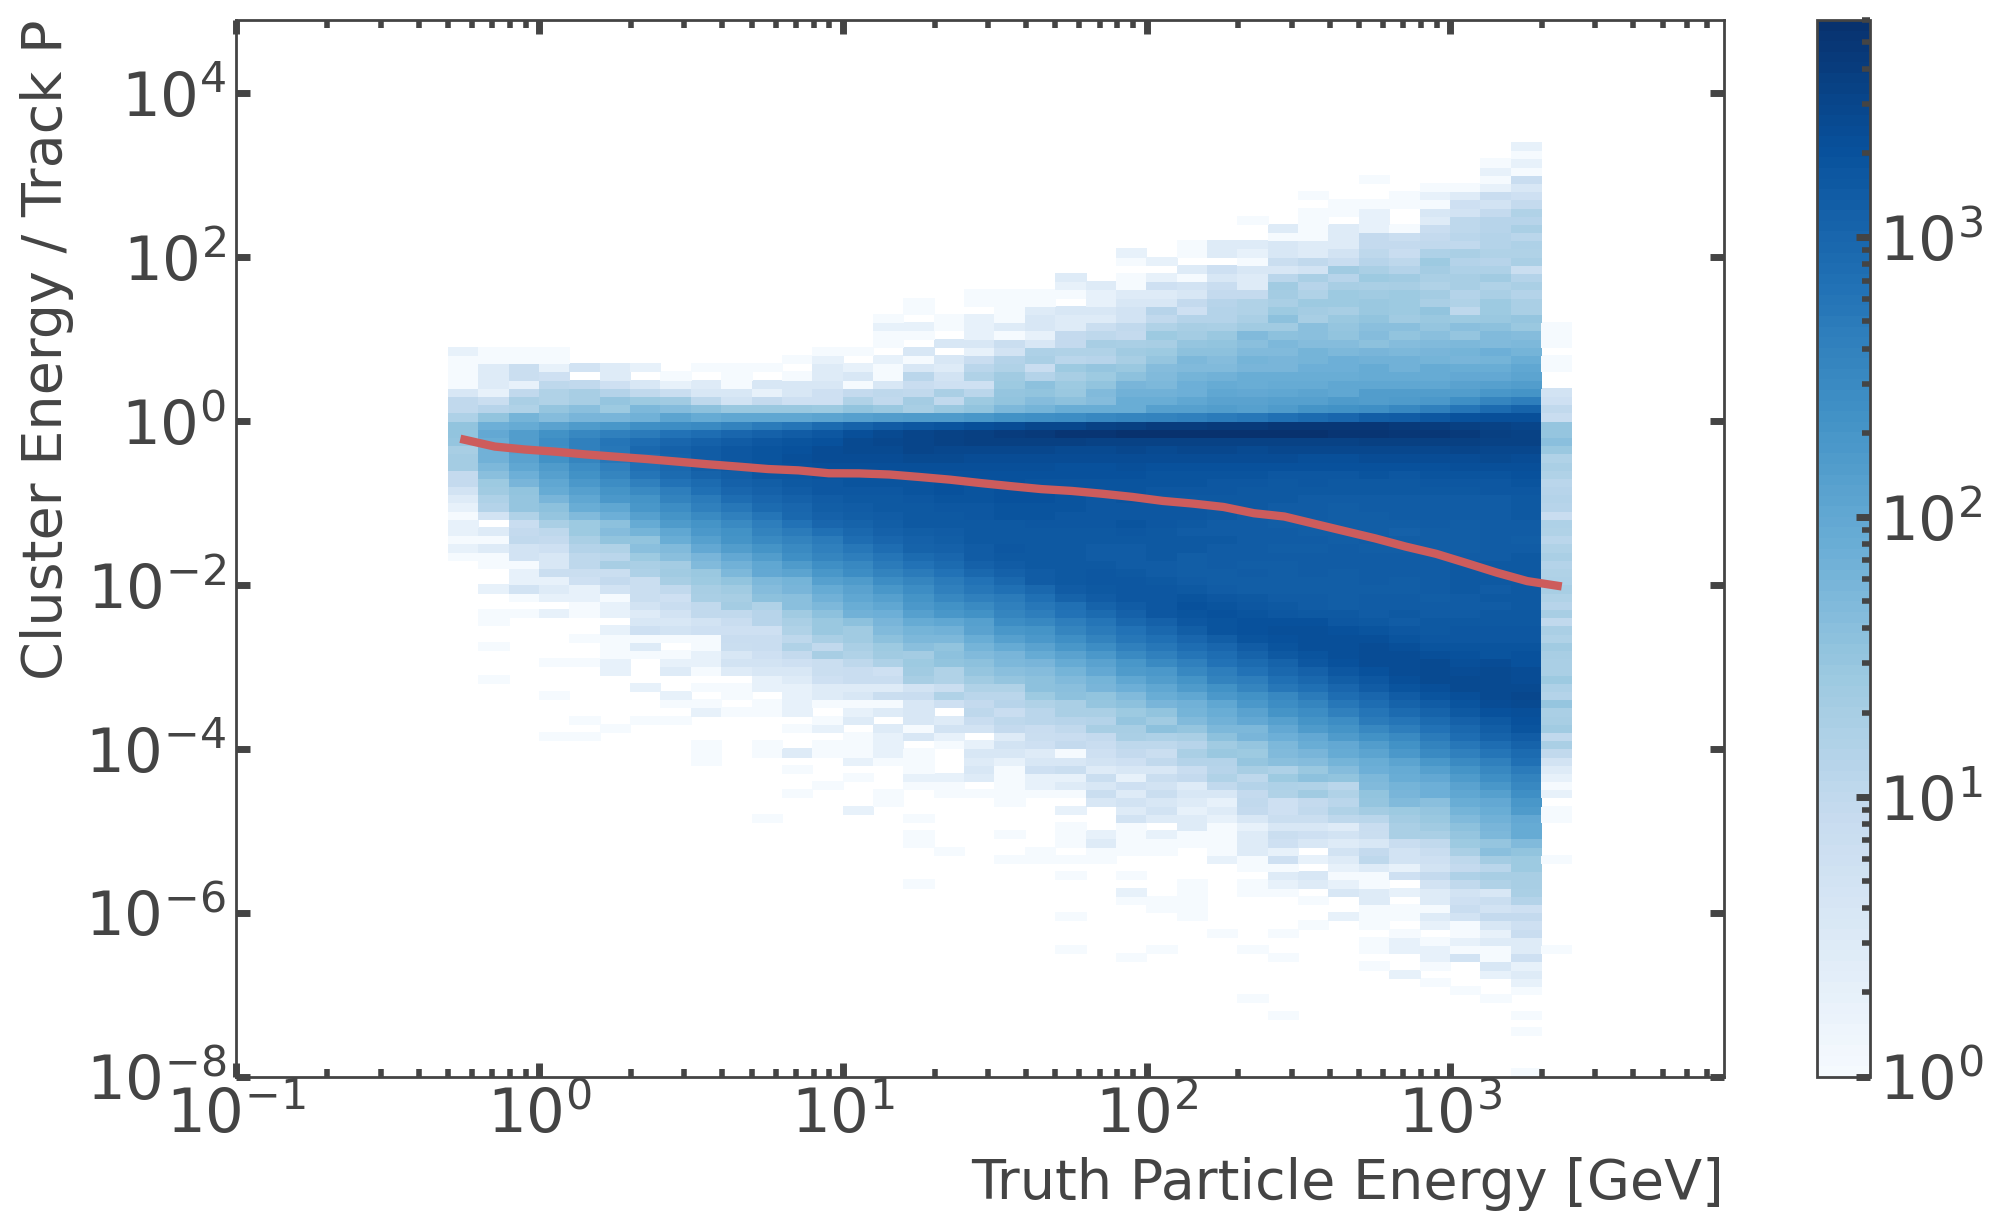

<Figure size 1600x1200 with 0 Axes>

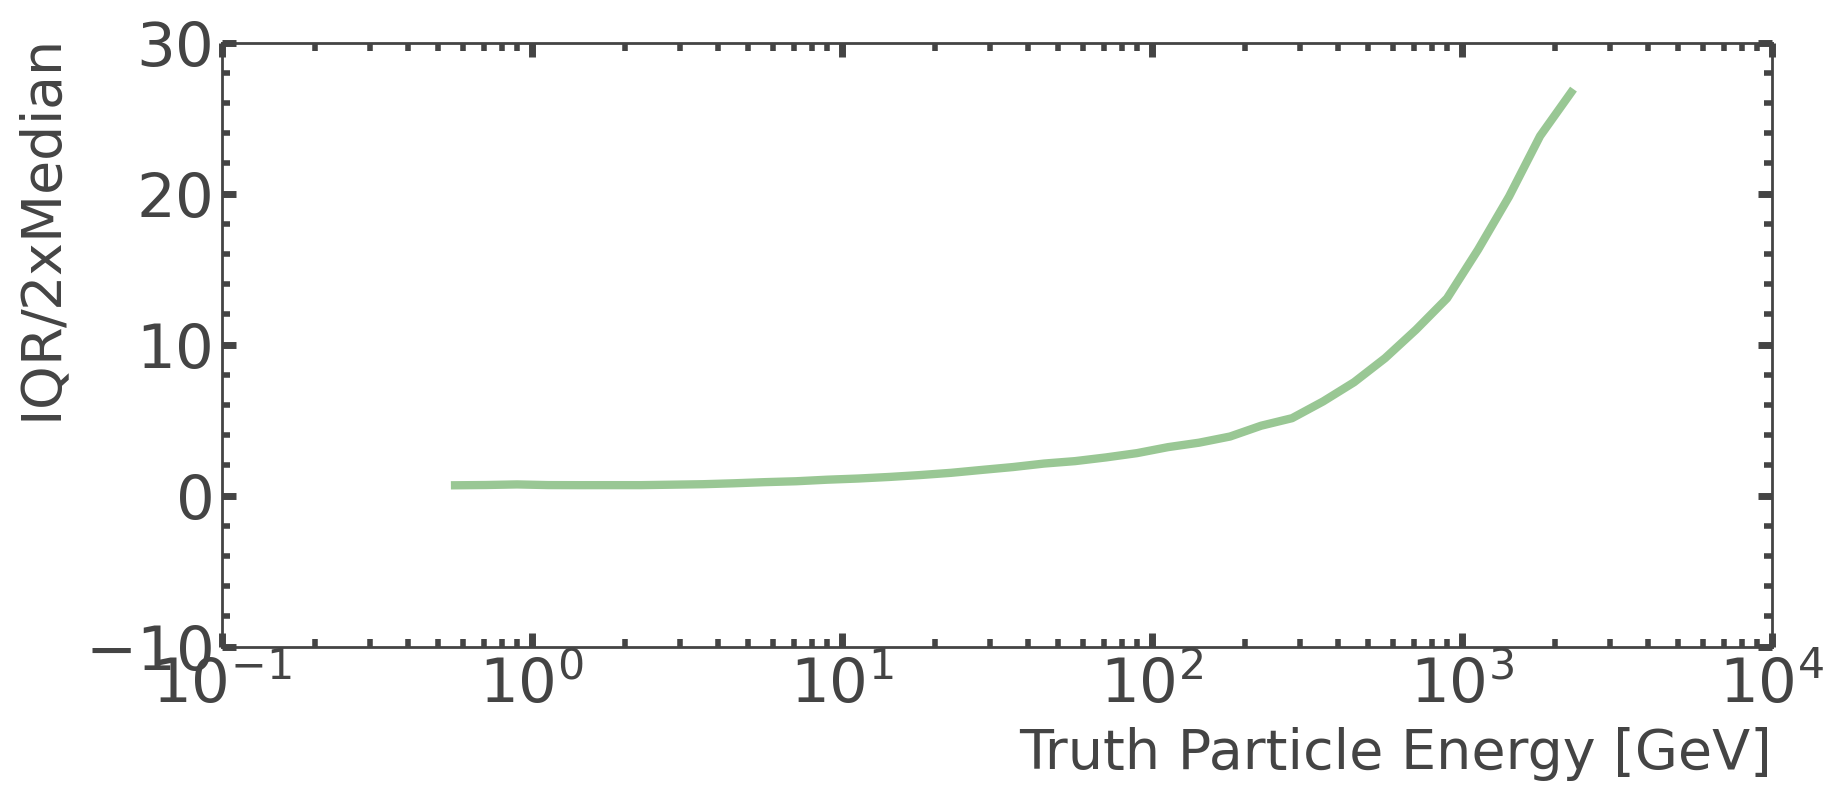

In [11]:
x_bins = [10**exp for exp in np.arange(-1, 4, .1)] 
y_bins = [10**exp for exp in np.arange(-8, 5, .1)]
trackP = df_expanded.track_P.astype(np.float32).values
cluster_E = df_expanded.cluster_E.astype(np.float32).values
ratio = cluster_E/trackP
truth_particle_e = df_expanded.truthPartE.astype(np.float32).values
histPlot(truth_particle_e, ratio, xbin=x_bins, ybin=y_bins,
         xscale='log', yscale='log', figsize=(12,7),
         xlabel='Truth Particle Energy [GeV]', ylabel='Cluster Energy / Track P')

resolutionPlot(truth_particle_e, ratio, xbin=x_bins,
               statistic='iqrOverMed',
               xlabel='Truth Particle Energy [GeV]', ylabel='$IQR/2xMedian$')

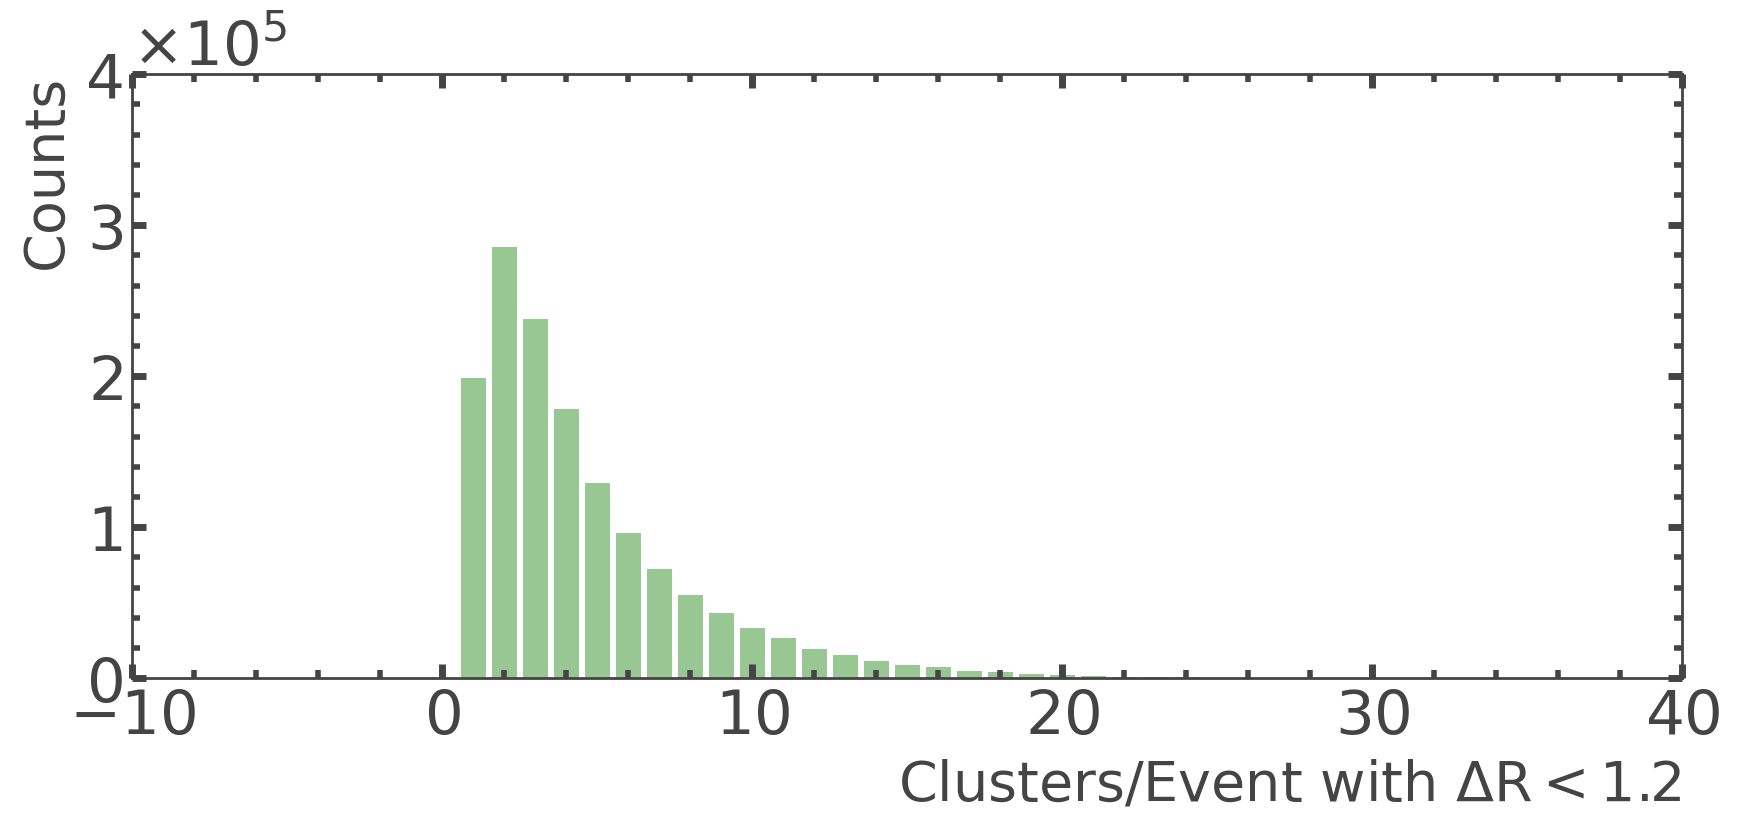

In [12]:
v, c = np.unique(df_expanded.dR_pass, return_counts=True)
plt.figure(figsize=(10,4))
plt.bar(v, c)
pu.ampl.set_xlabel('Clusters/Event with $\Delta R < 1.2$', fontsize=20)
pu.ampl.set_ylabel('Counts', fontsize=20)
plt.show()

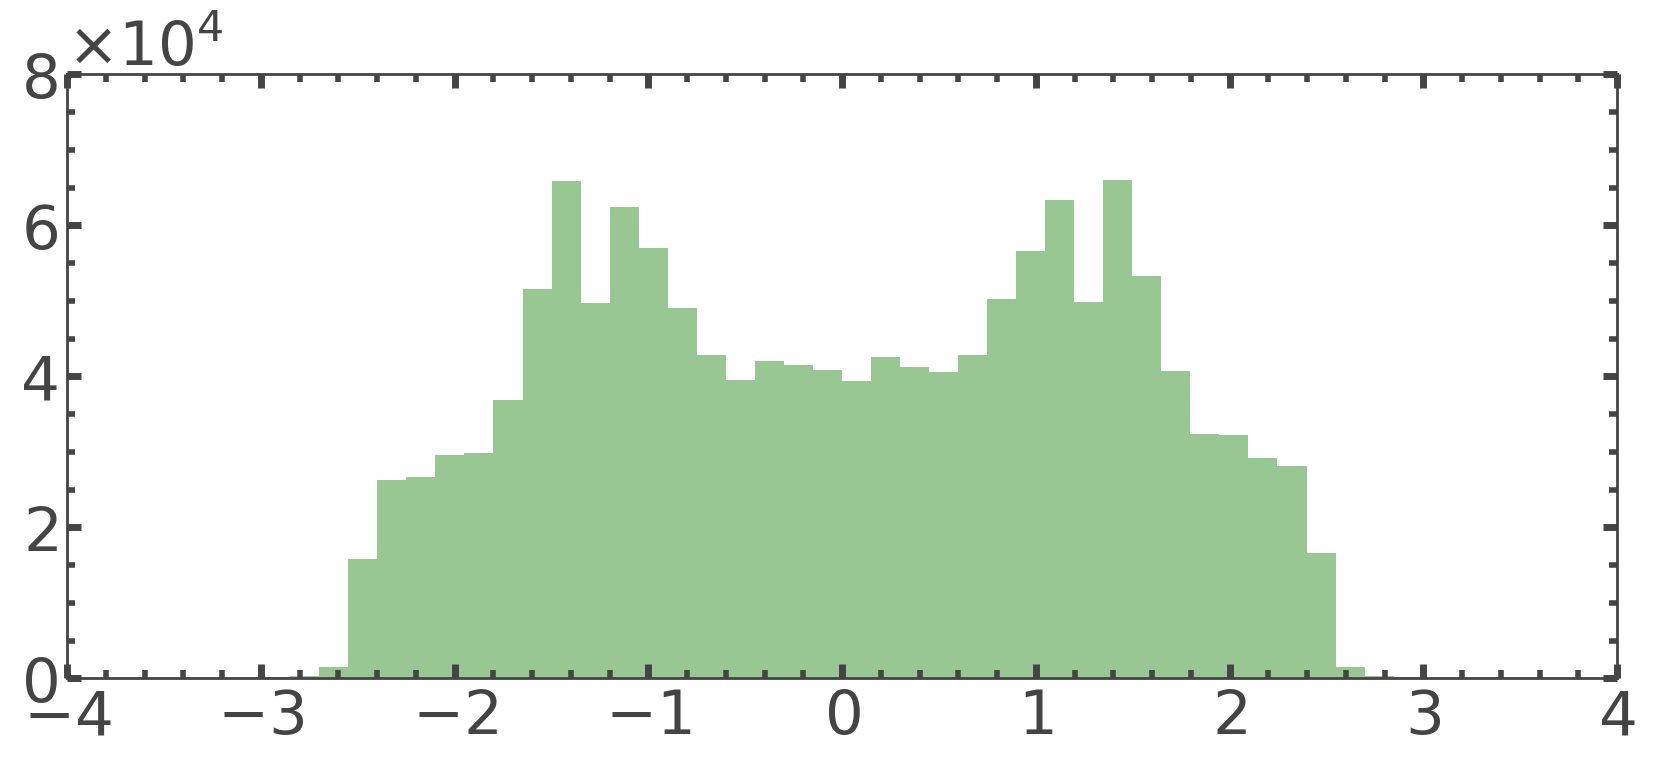

In [18]:
plt.figure(figsize=(10,4))
plt.hist(df_expanded.cluster_Eta, bins=40)
# pu.ampl.set_xlabel('Clusters/Event with $\Delta R < 1.2$', fontsize=20)
# pu.ampl.set_ylabel('Counts', fontsize=20)
plt.show()

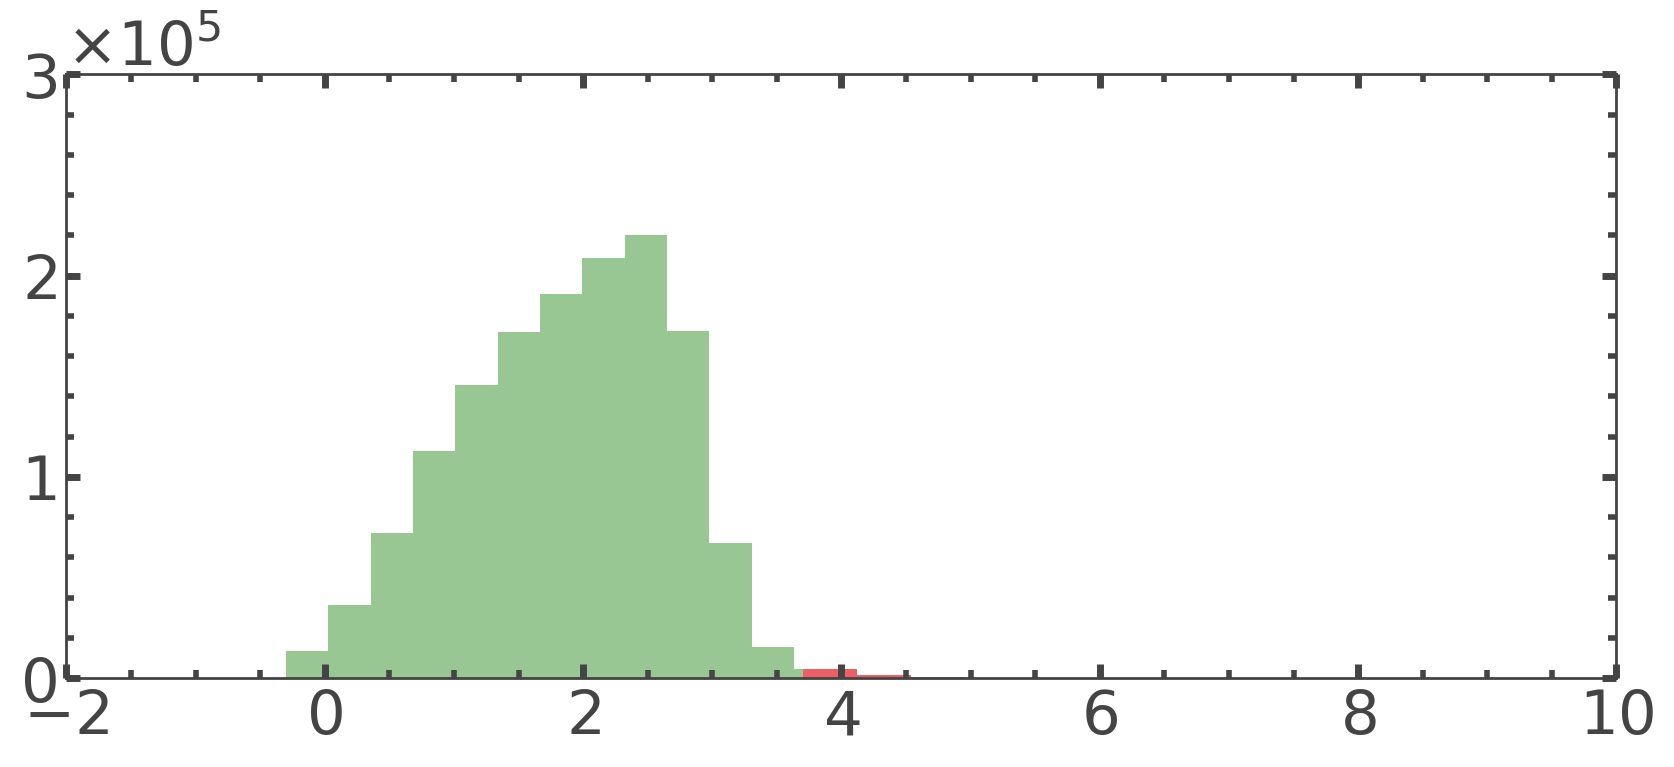

In [14]:
plt.figure(figsize=(10,4))
plt.hist(np.log10(df_expanded.trackPt.astype(np.float32)), bins=25)
plt.hist(np.log10(df_expanded.loc[df_expanded.trackPt>5000, 'trackPt'].astype(np.float32)))
# pu.ampl.set_xlabel('Clusters/Event with $\Delta R < 1.2$', fontsize=20)
# pu.ampl.set_ylabel('Counts', fontsize=20)
plt.show()

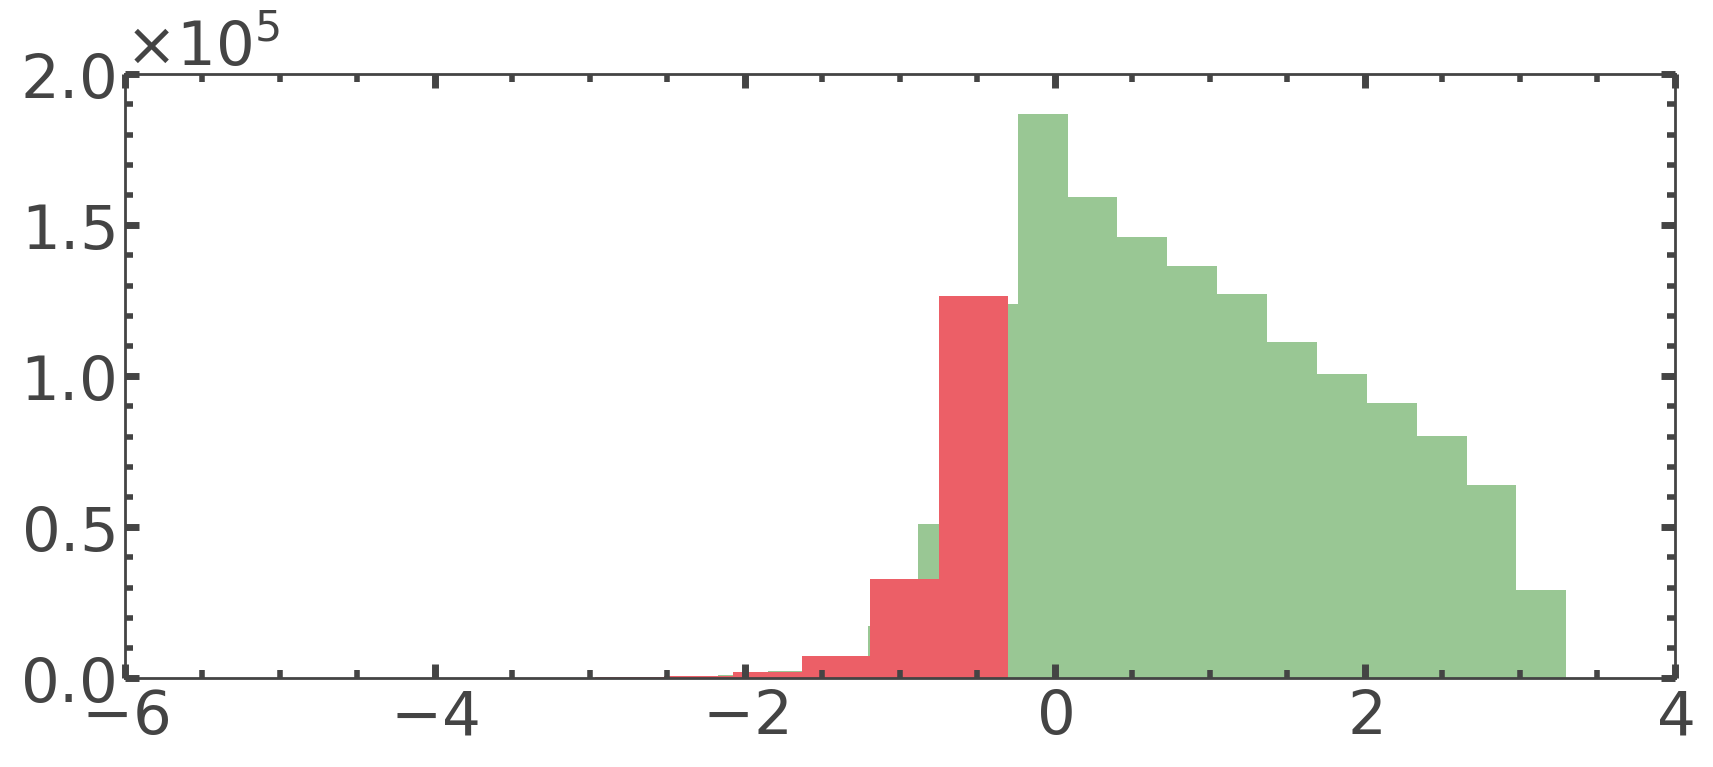

In [15]:
plt.figure(figsize=(10,4))
plt.hist(np.log10(df_expanded.cluster_E.astype(np.float32)), bins=25)
plt.hist(np.log10(df_expanded.loc[df_expanded.cluster_E<.5, 'cluster_E'].astype(np.float32)))
# pu.ampl.set_xlabel('Clusters/Event with $\Delta R < 1.2$', fontsize=20)
# pu.ampl.set_ylabel('Counts', fontsize=20)
plt.show()

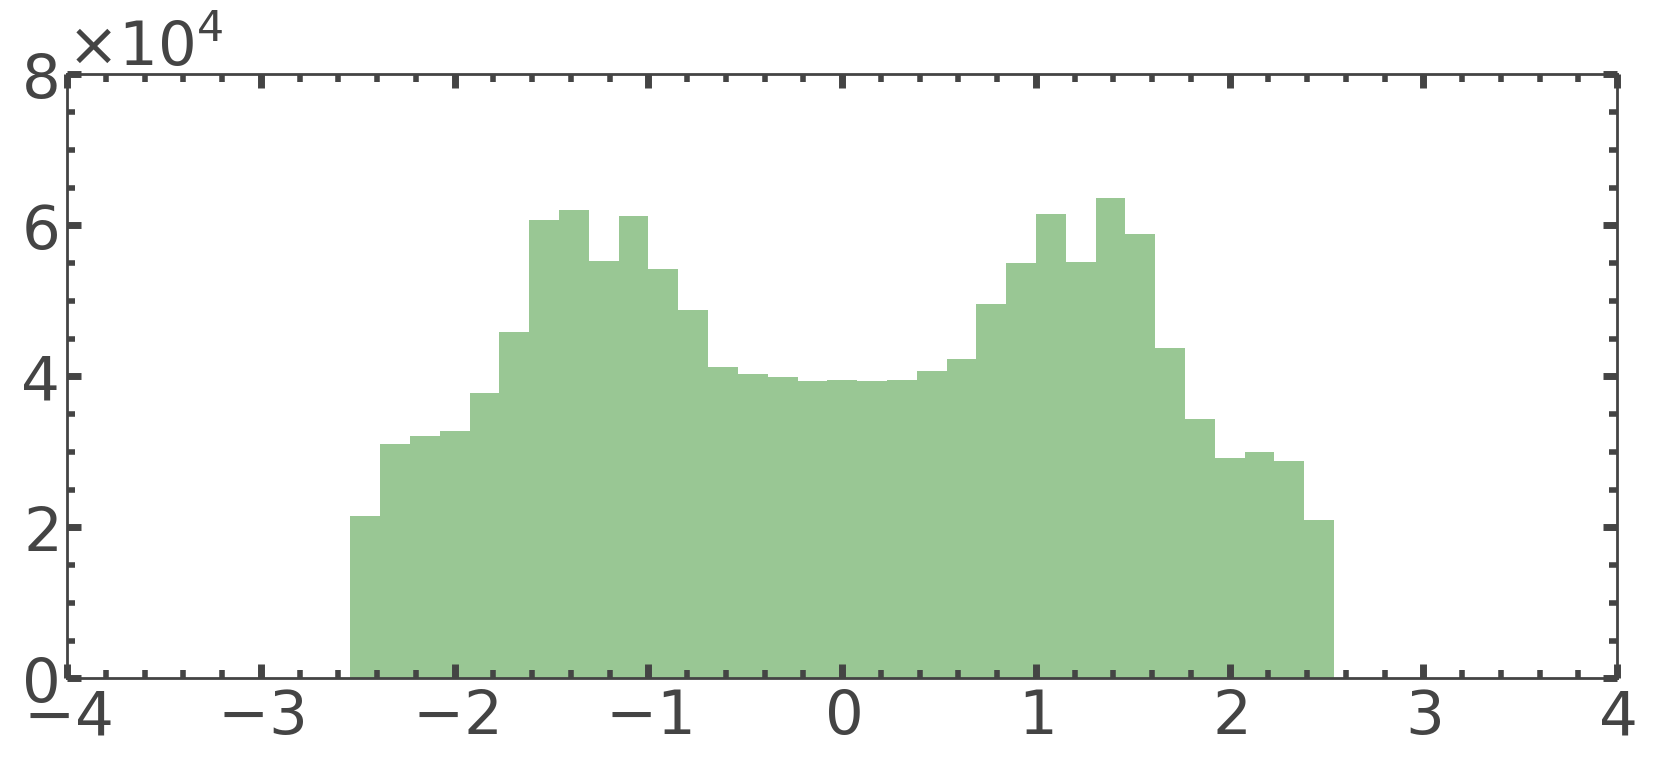

In [16]:
plt.figure(figsize=(10,4))
plt.hist(df_expanded.trackEta, bins=np.linspace(-3, 3, 40))
plt.show()

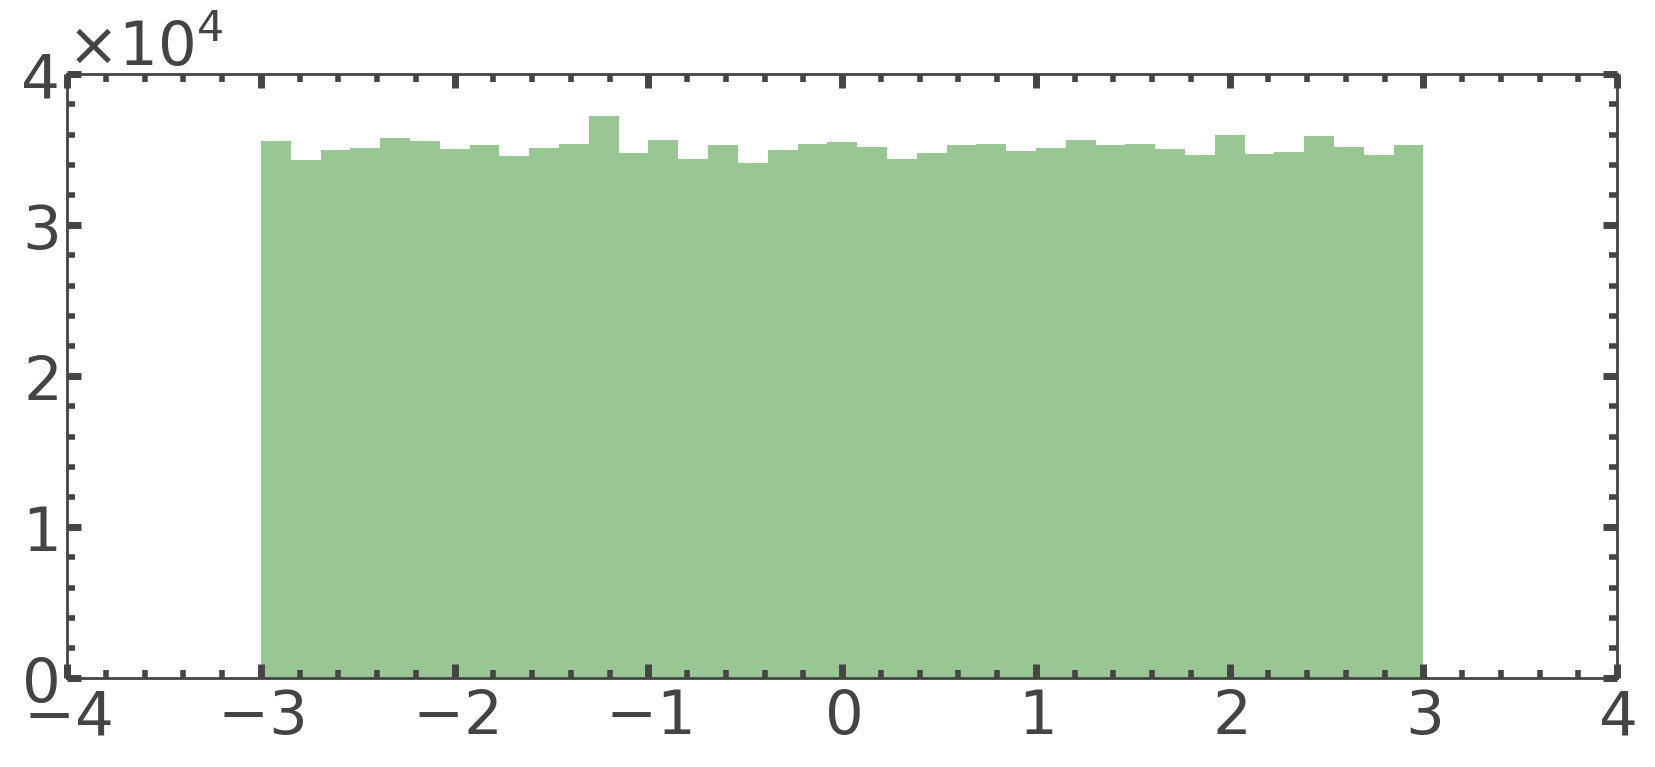

In [17]:
plt.figure(figsize=(10,4))
plt.hist(df_expanded.trackPhi, bins=np.linspace(-3, 3, 40))
plt.show()